In [1]:
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
auth_tok = ''
model_name = "meta-llama/Llama-2-7b-chat-hf"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code = True, token=auth_tok)

In [4]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

In [5]:
df = pd.read_json("../Data/clean_data.json")

In [6]:
system_prompt = """
<<SYS>>
You are an AI assistant that helps answer questions based on provided context. Here are things to pay attention to:

- First provide step-by-step reasoning on how to answer the question in the form <Reason>: $reason
- In the reasoning, if you need to reference some sentences from the context, include them in ##begin_quote## and ##end_quote##.
- End your response with a final answer in the form <Answer>: $answer. The answer should be succinct.
- <Document> tag in Context marks the beginning of a new document chunk.
<</SYS>>"""

In [5]:
def batchify_encode(content_list):
    batches = [content_list[i:i+1024] for i in range(0, len(content_list), 1024)]
    enc = []
    for batch in batches:
        encs = tokenizer.batch_encode_plus(batch)
        for i in range(len(batch)):
            enc.append(encs[i])
    return enc

In [8]:
sys_len = len(tokenizer.encode(system_prompt)) - 1

In [9]:
cot_ans = df.cot_answer.tolist()

In [10]:
cot_encs = batchify_encode(cot_ans)

In [11]:
cot_lens = []
for i in range(len(cot_ans)):
    cot_lens.append(len(cot_encs[i].ids))

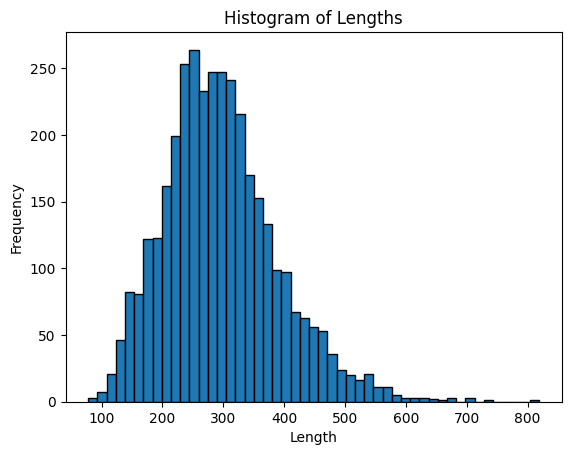

In [12]:
plt.hist(cot_lens, bins='auto', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [13]:
cot_lens = np.array(cot_lens)
(cot_lens > 550).argmax()

31

In [14]:
del cot_encs, cot_ans

In [15]:
oracle_ctxs = df.oracle_context.tolist()

In [16]:
oracle_enc = batchify_encode(oracle_ctxs)

In [17]:
oracle_lens = []
for i in range(len(oracle_ctxs)):
    oracle_lens.append(len(oracle_enc[i].ids))

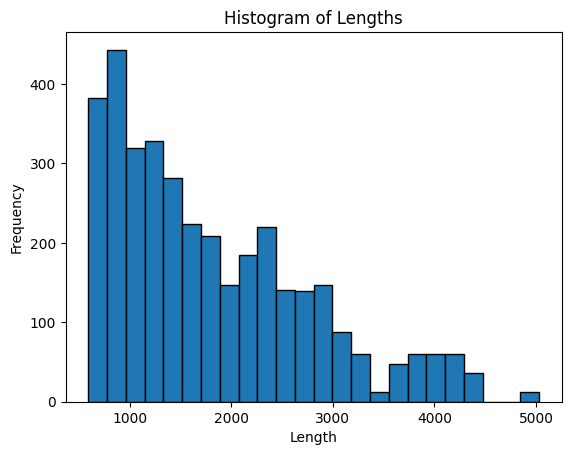

In [18]:
plt.hist(oracle_lens, bins='auto', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [19]:
oracle_lens = np.array(oracle_lens)

In [20]:
or_di = np.where(oracle_lens <= 2000)[0]
only_or = np.where(oracle_lens > 2000 )[0]
only_di_size = min(only_or.shape[0],int(oracle_lens.shape[0] * 0.2))
only_or,only_di = train_test_split(only_or,test_size=only_di_size)
only_or.sort()
or_di.sort()
only_di.sort()
del oracle_lens,oracle_ctxs

In [21]:
or_di.shape[0], only_or.shape[0], only_di.shape[0]

(2290, 592, 720)

In [22]:
ctxs = [" <Document> "+" <Document> ".join(c['sentences'][0][1:]) for c in df.copy().context]

In [23]:
enc = batchify_encode(ctxs)

In [24]:
del ctxs

In [25]:
or_di_encs = []
only_or_encs = []
only_di_encs = []
final_encs = []
ctx_type = []

In [26]:
for i in range(3602):
    surplus = 3000 - (sys_len + cot_lens[i])
    if i in only_or:
        input_list = oracle_enc[i].ids[1:]
        split_ids = [input_list[i:i + surplus] for i in range(0, len(input_list), surplus)]
        only_or_encs.append(split_ids)
        ctx_type.append("only_or")
    elif i in or_di:
        or_di_encs.append(oracle_enc[i].ids[1:] + enc[i].ids[1:(surplus-len(oracle_enc[i].ids))])
        ctx_type.append("or_di")
    else:
        only_di_encs.append(enc[i].ids[1:min(len(enc[i].ids[1:]),surplus)])
        ctx_type.append("only_di")

In [27]:
final_encs = [None for i in range(3602)]

In [28]:
for i,ids in enumerate(only_or_encs):
    ctx = tokenizer.batch_decode(ids)
    idx = only_or[i]
    final_encs[idx] = ctx

In [29]:
batches = [or_di_encs[i:i+1024] for i in range(0, len(or_di_encs), 1024)]

ids = []
for batch in batches:
    decs = tokenizer.batch_decode(batch)
    for i in range(len(batch)):
        ids.append(decs[i])

In [30]:
for i,ctx in enumerate(ids):
    idx = or_di[i]
    final_encs[idx] = ["<Document> "+ctx]

In [31]:
batches = [only_di_encs[i:i+1024] for i in range(0, len(only_di_encs), 1024)]

ids = []
for batch in batches:
    decs = tokenizer.batch_decode(batch)
    for i in range(len(batch)):
        ids.append(decs[i])

In [32]:
for i,ctx in enumerate(ids):
    idx = only_di[i]
    final_encs[idx] = [ctx]

In [33]:
question = []
cot_answer = []
context = []
c_type = []

In [34]:
for row in df.iterrows():
    idx  = row[0]
    for ctx in final_encs[idx]:
        question.append(row[1].question)
        cot_answer.append(row[1].cot_answer)
        if len(final_encs[idx]) > 1:
            context.append("<Document> "+ctx)
        else : 
            context.append(ctx)
        c_type.append(ctx_type[idx])

In [35]:
df_processed = pd.DataFrame({"question" : question, 'cot' :cot_answer, 'context' : context, 'type' : c_type})

In [36]:
df_processed

,question,cot,context,type
0,What are zombie systems used for by hackers?,<Reason>: To answer the question about what z...,<Document> The TLB contains\n\n\nonly a few o...,only_di
1,How do zombies make hackers difficult to track?,"<Reason>: To answer the question ""How do zomb...",<Document> Another modification is to keep a ...,only_di
2,What is a denial-of-service attack aimed at?,"<Reason>: To answer the question ""What is a d...","<Document> First, note that\n\n\nWindows allo...",only_di
3,What are the two categories of denial-of-servi...,<Reason>: To answer the question about the tw...,<Document> All hackers leave tracks behind the...,only_or
4,What are the two categories of denial-of-servi...,<Reason>: To answer the question about the tw...,"<Document> addresses, however, keys are design...",only_or
...,...,...,...,...
3960,How can a user run a process in the background...,<Reason>: To answer the question on how a use...,"<Document> It is gone with the wind, forever.\...",or_di
3961,What are shell scripts in Linux?,"<Reason>: To answer the question ""What are sh...","<Document> It is gone with the wind, forever.\...",or_di
3962,How are shell scripts executed in Linux?,"<Reason>: To answer the question ""How are she...","<Document> It is gone with the wind, forever.\...",or_di
3963,What is the Berkeley C shell in Linux?,"<Reason>: To answer the question ""What is the...","<Document> It is gone with the wind, forever.\...",or_di


In [6]:
df_processed.to_csv("../Data/Train_data/processed_finetune_data.csv",index=False)

NameError: name 'df_processed' is not defined

In [6]:
def make_instruction(ctx, question,answer):
    system_prompt = """
<<SYS>>
You are an AI assistant that helps answer questions based on provided context. Here are things to pay attention to:

- First provide step-by-step reasoning on how to answer the question in the form <Reason>: $reason
- In the reasoning, if you need to reference some sentences from the context, include them in ##begin_quote## and ##end_quote##.
- End your response with a final answer in the form <Answer>: $answer. The answer should be succinct.
- <Document> tag in Context marks the beginning of a new document chunk.
- If you cannot find answer in context, answer by yourself without providing false information. 
<</SYS>>"""

    user_prompt = f"""
Answer this Question: {question}
using the Context: {ctx}
"""
    prompt = f"[INST] {system_prompt} \n{user_prompt} [/INST] \n[START]{answer}"
    return prompt


In [7]:
df = pd.read_csv("../Data/Train_data/processed_finetune_data.csv")

In [8]:
text = []
for _,row in df.iterrows():
    text.append(make_instruction(row.context,row.question,row.cot))
    

In [9]:
encs = batchify_encode(text)

In [10]:
lens = []
for i in range(len(text)):
    lens.append(len(encs[i].ids))

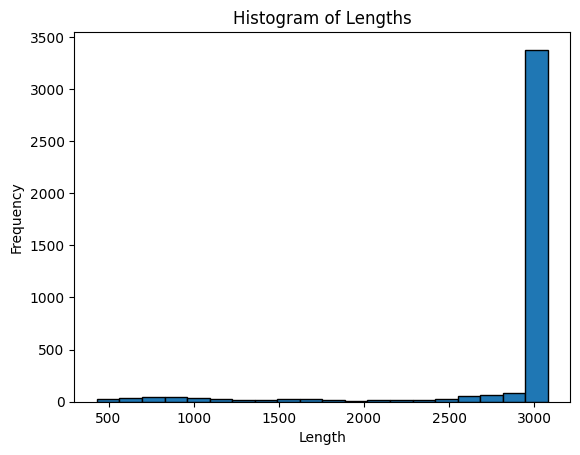

In [11]:
plt.hist(lens, bins=20, edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [12]:
df['text'] = text

In [13]:
df.to_csv("../Data/Train_data/processed_finetune_data.csv")

In [14]:
text[0]

"[INST] \n<<SYS>>\nYou are an AI assistant that helps answer questions based on provided context. Here are things to pay attention to:\n\n- First provide step-by-step reasoning on how to answer the question in the form <Reason>: $reason\n- In the reasoning, if you need to reference some sentences from the context, include them in ##begin_quote## and ##end_quote##.\n- End your response with a final answer in the form <Answer>: $answer. The answer should be succinct.\n- <Document> tag in Context marks the beginning of a new document chunk.\n- If you cannot find answer in context, answer by yourself without providing false information. \n<</SYS>> \n\nAnswer this Question: What are zombie systems used for by hackers?\nusing the Context:  <Document> The TLB contains\n\n\nonly a few of the page-table entries. When a logical address is generated by\nthe CPU , the MMU first checks if its page number is present in the TLB . If the\npage number is found, its frame number is immediately available